### **TITLE:  Performance Analysis of Different Neural Networks for Sentiment Analysis on IMDb Movie Reviews**
### **DATASCIENCE PROJECT**
#### **Members:**
#####         **Insha Javed K213279**
#####         **Muhammad Tahir K214503**
#####         **Muhammad Samamah K213205**

# ***--------------------------------------------------------------------------------***

### **About the Project:**

#### Sentiment analysis is the process of determining the sentiment (positive, negative, or neutral) expressed in a piece of text. In this project, we aim to do performance analysis of 4 different neural network-based models (CNN, LSTM, CNN-LSTM, AND LDA) for sentiment analysis using the Large Movie Review Dataset v1.0 by the STANFORD UNIVERSITY, which contains movie reviews along with their associated binary sentiment polarity labels (1 or 0). The dataset serves as a benchmark for sentiment classification tasks. The core dataset consists of 50,000 movie reviews evenly split into 25,000 training and 25,000 testing sets. The labels are balanced, with 25,000 positive and 25,000 negative reviews. Additionally, there are 50,000 unlabeled documents included for unsupervised learning. The reviews have been carefully selected to ensure diversity, with no more than 30 reviews allowed for any given movie. Negative reviews have scores of 4 or lower out of 10, while positive reviews have scores of 7 or higher out of 10. The unsupervised set includes reviews of any rating.

# ***--------------------------------------------------------------------------------***

#### **Import Libraries:**

In [ ]:
import os
import re
import nltk
import pickle
import joblib
import numpy as np
import pandas as pd
import warnings

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.utils import to_categorical
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# for GUI purposes
import tkinter as tk
from tkinter import messagebox

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob

warnings.filterwarnings("ignore")
stop_words = set(stopwords.words('english'))

#### **Preprocessing**

In [ ]:
# Define the paths to dataset
train_dir_pos = 'aclImdb/aclImdb/train/pos'
train_dir_neg = 'aclImdb/aclImdb/train/neg'
train_dir_unsup = 'aclImdb/aclImdb/train/unsup'
test_dir_pos = 'aclImdb/aclImdb/test/pos'
test_dir_neg = 'aclImdb/aclImdb/test/neg'

# Function to load the positive reviews
def load_data_pos(dir):
    reviews = []
    labels = []
    # Load positive reviews
    for fname in os.listdir(dir):
        if fname.endswith('.txt'):
            with open(os.path.join(dir, fname), encoding='utf-8') as f:
                review = f.read()
                reviews.append(review)
                labels.append(1)
    return reviews, labels

# Function to load the negative reviews
def load_data_neg(dir):
    reviews = []
    labels = []
    # Load negative reviews
    for fname in os.listdir(dir):
        if fname.endswith('.txt'):
            with open(os.path.join(dir, fname), encoding='utf-8') as f:
                review = f.read()
                reviews.append(review)
                labels.append(0)
    return reviews, labels

# Function to load the unsupervised reviews
def load_unsupervised_data(dir):
    reviews = []
    for fname in os.listdir(dir):
        if fname.endswith('.txt'):
            with open(os.path.join(dir, fname), encoding='utf-8') as f:
                review = f.read()
                reviews.append(review)
    return reviews

# Basic text preprocessing
def preprocess_texts(texts):
    texts = [re.sub(r'"/>|<br>', '', text) for text in texts]
    texts = [re.sub(r'<.*?>', '', text) for text in texts]
    texts = [re.sub(r'[^a-zA-Z\s]', '', text) for text in texts]
    texts = [text.lower() for text in texts]
    return texts

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function for lemmatization
def lemmatize_text(texts):
    return [' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) for text in texts]

## **GUI Functions**

In [ ]:
def preprocess_review(review, tokenizer=None, maxlen=None, vectorizer=None, lda=None):
    review = preprocess_texts([review])  # Basic preprocessing
    if tokenizer and maxlen:  # For CNN, LSTM, and LSTM-CNN
        sequences = tokenizer.texts_to_sequences(review)
        return pad_sequences(sequences, maxlen=maxlen)
    elif vectorizer and lda:  # For LDA
        review_vector = vectorizer.transform(review)
        return lda.transform(review_vector)
    return None

# Prediction function
def predict_sentiment(review, model, tokenizer=None, maxlen=None, vectorizer=None, lda=None, classifier=None):
    if tokenizer or vectorizer:
        input_data = preprocess_review(review, tokenizer, maxlen, vectorizer, lda)
        if tokenizer:  # For CNN, LSTM, and LSTM-CNN
            y_pred = model.predict(input_data)
            sentiment = "positive" if np.argmax(y_pred, axis=1)[0] == 1 else "negative"
        elif classifier:  # For LDA
            sentiment = "positive" if classifier.predict(input_data)[0] == 1 else "negative"
        return sentiment
    return "Error: Model inputs are not properly configured."

# GUI creation function
def create_gui(model_name, model, tokenizer=None, maxlen=None, vectorizer=None, lda=None, classifier=None):
    def on_predict_button_click():
        review = review_entry.get("1.0", 'end-1c').strip()  # Get review text
        if review:
            sentiment = predict_sentiment(review, model, tokenizer, maxlen, vectorizer, lda, classifier)
            sentiment_label.config(text=f"Predicted Sentiment: {sentiment}")
        else:
            messagebox.showwarning("Input Error", "Please enter a review before predicting.")

    # Create main window
    root = tk.Tk()
    root.title(f"{model_name.upper()} FOR SENTIMENT ANALYSIS")
    root.configure(bg="black")

    # Configure layout
    root.grid_columnconfigure(0, weight=1)
    for i in range(4):
        root.grid_rowconfigure(i, weight=1)

    # Add widgets
    tk.Label(root, text=f"{model_name.upper()} FOR SENTIMENT ANALYSIS", bg="black", fg="white", font=("Helvetica", 20)).grid(row=0, column=0, pady=10)
    tk.Label(root, text="Enter your review:", bg="black", fg="white", font=("Helvetica", 16)).grid(row=1, column=0, pady=10)

    review_entry = tk.Text(root, width=80, height=10)
    review_entry.grid(row=2, column=0, pady=5)

    predict_button = tk.Button(root, text="Predict Sentiment", command=on_predict_button_click, bg="white", fg="black")
    predict_button.grid(row=3, column=0, pady=10)

    sentiment_label = tk.Label(root, text="", bg="black", fg="white", font=("Helvetica", 16))
    sentiment_label.grid(row=4, column=0, pady=10)

    # Run application
    root.mainloop()

### **Load training & testing data**

In [ ]:
# Load training data
train_reviews_pos, train_labels_pos = load_data_pos(train_dir_pos)
train_reviews_neg, train_labels_neg = load_data_neg(train_dir_neg)
train_reviews = train_reviews_pos + train_reviews_neg
train_labels = train_labels_pos + train_labels_neg

# Load unsupervised reviews
unsup_reviews = load_unsupervised_data(train_dir_unsup)

# Load testing data
test_reviews_pos, test_labels_pos = load_data_pos(test_dir_pos)
test_reviews_neg, test_labels_neg = load_data_neg(test_dir_neg)
test_reviews = test_reviews_pos + test_reviews_neg
test_labels = test_labels_pos + test_labels_neg

In [ ]:
# Save the reviews and labels to a file
with open('train_reviews.pkl', 'wb') as f:
    pickle.dump((train_reviews, train_labels), f)

with open('test_reviews.pkl', 'wb') as f:
    pickle.dump((test_reviews, test_labels), f)

with open('unsup_reviews.pkl', 'wb') as f:
     pickle.dump(unsup_reviews, f)

## **Performing EDA**

In [ ]:
# Load training data
with open('train_test_data/train_reviews.pkl', 'rb') as f:
    train_reviews, train_labels = pickle.load(f)

# Load testing data
with open('train_test_data/test_reviews.pkl', 'rb') as f:
    test_reviews, test_labels = pickle.load(f)

# Load unsupervised reviews
with open('train_test_data/unsup_reviews.pkl', 'rb') as f:
    train_reviews_unsup = pickle.load(f)

# training reviews into a DataFrame
train_data = pd.DataFrame({
    'review': train_reviews,
    'label': train_labels
})

# testing reviews into a DataFrame
test_data = pd.DataFrame({
    'review': test_reviews,
    'label': test_labels
})

# unsupervised reviews into a DataFrame
unsup_data = pd.DataFrame({
    'review': train_reviews_unsup
})

In [ ]:
print("Training Reviews: \n", train_data.head())
print("\nTraining Reviews: \n", test_data.head())

Training Reviews: 
                                               review  label
0  Bromwell High is a cartoon comedy. It ran at t...      1
1  Homelessness (or Houselessness as George Carli...      1
2  Brilliant over-acting by Lesley Ann Warren. Be...      1
3  This is easily the most underrated film inn th...      1
4  This is not the typical Mel Brooks film. It wa...      1

Training Reviews: 
                                               review  label
0  i went and saw this movie last night after bei...      1
1  actor turned director bill paxton follows up h...      1
2  as a recreational golfer with some knowledge o...      1
3  i saw this film in a sneak preview and it is d...      1
4  bill paxton has taken the true story of the  u...      1


### **Frequency of Classes**

In [ ]:
print("Training Reviews: \n",train_data['label'].value_counts())
print("\nTesting Reviews: \n",test_data['label'].value_counts())

Training Reviews: 
 label
1    12500
0    12500
Name: count, dtype: int64

Testing Reviews: 
 label
1    12500
0    12500
Name: count, dtype: int64


#### **Most Common Words Before Processing**

In [ ]:
# Tokenize and filter stopwords
words = ' '.join(train_data['review']).split()
filtered_words = [word for word in words if word.lower() not in stop_words]

# Most common words
word_counts = Counter(filtered_words).most_common(20)
print(word_counts)

[('/><br', 50935), ('movie', 30506), ('film', 27402), ('one', 20692), ('like', 18133), ('would', 11923), ('good', 11436), ('really', 10815), ('even', 10607), ('see', 10155), ('-', 9355), ('get', 8777), ('story', 8527), ('much', 8507), ('time', 7765), ('make', 7485), ('could', 7462), ('also', 7422), ('first', 7339), ('people', 7335)]


#### **Preprocessing**

In [ ]:
train_data['review'] = preprocess_texts(train_data['review'])
test_data['review'] = preprocess_texts(test_data['review'])

#### **Most Common Words After Preprocessing**

In [ ]:
# Tokenize and filter stopwords
words = ' '.join(train_data['review']).split()
filtered_words = [word for word in words if word.lower() not in stop_words]

# Most common words
word_counts = Counter(filtered_words).most_common(20)
print(word_counts)

[('movie', 41826), ('film', 37489), ('one', 25166), ('like', 19568), ('good', 14516), ('even', 12328), ('would', 12124), ('time', 11808), ('really', 11642), ('story', 11438), ('see', 11179), ('much', 9550), ('well', 9201), ('get', 9200), ('people', 8926), ('bad', 8904), ('also', 8899), ('great', 8849), ('first', 8689), ('dont', 8329)]


#### **Word Cloud Visualization**

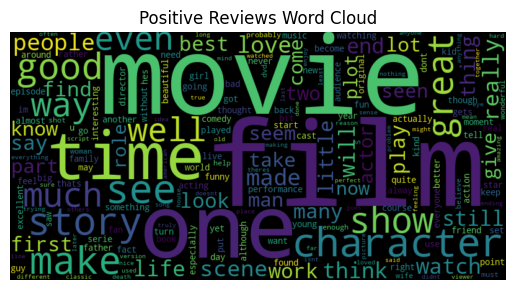

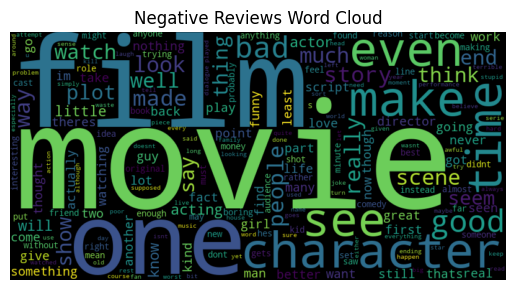

In [ ]:
positive_reviews = ' '.join(train_data[train_data['label'] == 1]['review'])
negative_reviews = ' '.join(train_data[train_data['label'] == 0]['review'])

wc_positive = WordCloud(width=800, height=400).generate(positive_reviews)
wc_negative = WordCloud(width=800, height=400).generate(negative_reviews)

plt.imshow(wc_positive, interpolation='bilinear')
plt.title('Positive Reviews Word Cloud')
plt.axis('off')
plt.show()

plt.imshow(wc_negative, interpolation='bilinear')
plt.title('Negative Reviews Word Cloud')
plt.axis('off')
plt.show()

#### **Save Training and Testing Reviews lengths**

In [ ]:
train_data['text_length'] = train_data['review'].apply(len)
test_data['text_length'] = test_data['review'].apply(len)

#### **Histogram of Training Reviews lengths**

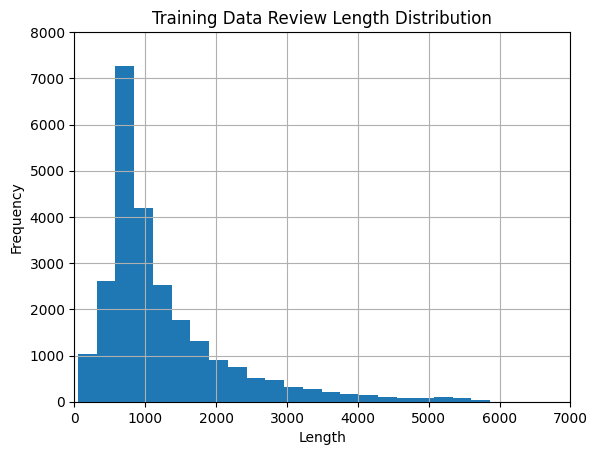

In [ ]:
train_data['text_length'].hist(bins=50)
plt.title('Training Data Review Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.xlim(0, 7000)
plt.ylim(0, 8000)
plt.show()

#### **Histogram of Testing Reviews lengths**

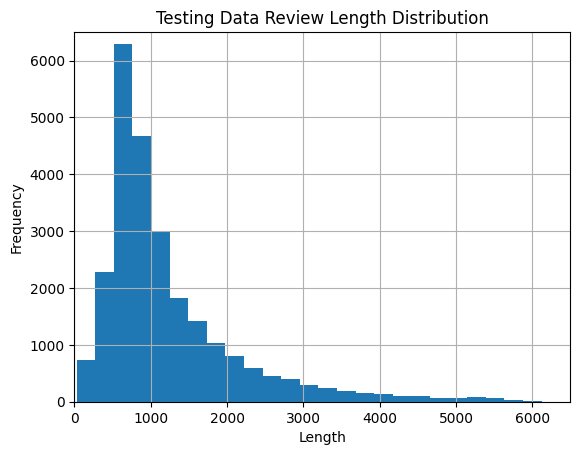

In [ ]:
test_data['text_length'].hist(bins=50)
plt.title('Testing Data Review Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.xlim(0, 6500)
plt.ylim(0, 6500)
plt.show()

#### **Polarity Distribution On Training Data**

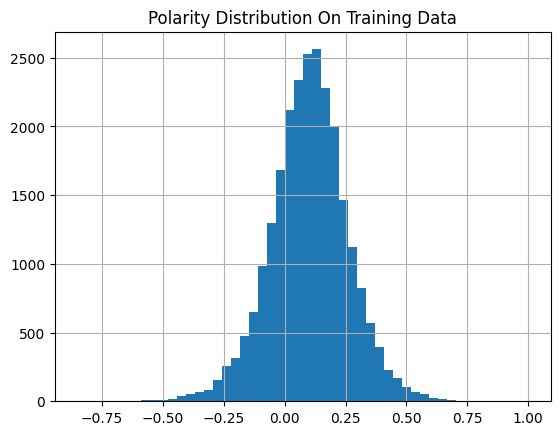

In [ ]:
train_data['polarity'] = train_data['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Distribution of polarity
train_data['polarity'].hist(bins=50)
plt.title('Polarity Distribution On Training Data')
plt.show()

#### **Polarity Distribution On Testing Data**

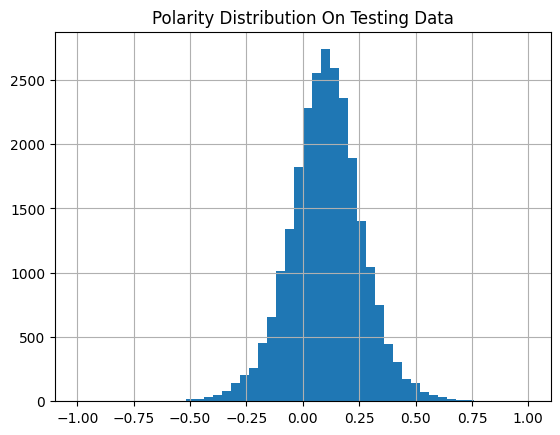

In [ ]:
test_data['polarity'] = test_data['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Distribution of polarity
test_data['polarity'].hist(bins=50)
plt.title('Polarity Distribution On Testing Data')
plt.show()

## **Lemmatization and Tokenization**

In [ ]:
# Lemmatize the reviews
x_train = lemmatize_text(train_reviews)
x_test = lemmatize_text(test_reviews)

# Tokenize the reviews
max_words = 8000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_reviews)
x_train = tokenizer.texts_to_sequences(train_reviews)
x_test = tokenizer.texts_to_sequences(test_reviews)

# Pad sequences to a maximum review length
max_review_length = 500
x_train = pad_sequences(x_train, maxlen=max_review_length)
x_test = pad_sequences(x_test, maxlen=max_review_length)

# One-hot encode the labels
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# Save the tokenized and padded sequences
np.save('train_test_data/x_train.npy', x_train)
np.save('train_test_data/x_test.npy', x_test)

# Save the one-hot encoded labels
np.save('train_test_data/y_train.npy', y_train)
np.save('train_test_data/y_test.npy', y_test)

# Save the tokenizer
with open('train_test_data/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### **Load the preprocessed data**

In [ ]:
# Load the reviews and labels from the file
with open('train_test_data/train_reviews.pkl', 'rb') as f:
    train_reviews, train_labels = pickle.load(f)

with open('train_test_data/test_reviews.pkl', 'rb') as f:
    test_reviews, test_labels = pickle.load(f)

with open('train_test_data/unsup_reviews.pkl', 'rb') as f:
    train_reviews_unsup = pickle.load(f)

# Load the tokenized and padded sequences
x_train = np.load('train_test_data/x_train.npy')
x_test = np.load('train_test_data/x_test.npy')

# Load the one-hot encoded labels
y_train = np.load('train_test_data/y_train.npy')
y_test = np.load('train_test_data/y_test.npy')

# Load the tokenizer
with open('train_test_data/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

max_words = 8000
max_review_length = 500

### ***1st Model:*** **CNN Model**

In [ ]:
# Load the model
cnn_model = load_model('trained_models/CNN_model.keras')
cnn_model

<Sequential name=sequential, built=True>

In [ ]:
# Predict the test set
y_pred_cnn = cnn_model.predict(x_test)

# Convert predictions to class labels
y_pred_labels = [1 if pred[1] > pred[0] else 0 for pred in y_pred_cnn]

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test_labels, y_pred_labels)
precision = precision_score(test_labels, y_pred_labels)
recall = recall_score(test_labels, y_pred_labels)
f1 = f1_score(test_labels, y_pred_labels)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_pred_labels).ravel()

# Calculate specificity
specificity = tn / (tn + fp)

# Print all metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Accuracy: 0.86
Recall: 0.83
Specificity: 0.90
Precision: 0.89
F1 Score: 0.86


### ***GUI Interface for predictoin***

In [ ]:
create_gui("CNN", cnn_model, tokenizer=tokenizer, maxlen=max_review_length)

### ***2nd Model:*** **LSTM Model**

In [ ]:
# Load the model
lstm_model = load_model('trained_models/LSTM_model.keras')

In [ ]:
# Predict the test set
y_pred_lstm = lstm_model.predict(x_test)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test_labels, y_pred_lstm)
precision = precision_score(test_labels, y_pred_lstm)
recall = recall_score(test_labels, y_pred_lstm)
f1 = f1_score(test_labels, y_pred_lstm)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_pred_lstm).ravel()

# Calculate specificity
specificity = tn / (tn + fp)

# Print all metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step
Accuracy: 0.84
Recall: 0.76
Specificity: 0.92
Precision: 0.90
F1 Score: 0.83


### ***GUI Interface for predictoin***

In [ ]:
create_gui("LSTM", lstm_model, tokenizer=tokenizer, maxlen=max_review_length)

### ***3rd Model:*** **CNN-LSTM Model**

In [ ]:
# Load the model
lstm_cnn_model = load_model('trained_models/LSTM_CNN_model.keras')

In [ ]:
# Predict the test set
y_pred_lstm_cnn = lstm_cnn_model.predict(x_test)

# Convert predictions to class labels
y_pred_labels = [1 if pred[1] > pred[0] else 0 for pred in y_pred_lstm_cnn]

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test_labels, y_pred_labels)
precision = precision_score(test_labels, y_pred_labels)
recall = recall_score(test_labels, y_pred_labels)
f1 = f1_score(test_labels, y_pred_labels)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_pred_labels).ravel()

# Calculate specificity
specificity = tn / (tn + fp)

# Print all metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step
Accuracy: 0.87
Recall: 0.86
Specificity: 0.88
Precision: 0.88
F1 Score: 0.87


### ***GUI Interface for predictoin***

In [ ]:
create_gui("LSTM-CNN", lstm_cnn_model, tokenizer=tokenizer, maxlen=max_review_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


### ***4th Model:*** **LDA Model**

In [ ]:
# Load the LDA model
lda = joblib.load('trained_models/lda_model.pkl')

# Load the vectorizer
vectorizer = joblib.load('trained_models/vectorizer_model.pkl')

# Load the logistic regression classifier
classifier = joblib.load('trained_models/classifier_model.pkl')

In [ ]:
# Combine all reviews for vectorization
all_reviews = train_reviews + train_reviews_unsup

X = vectorizer.fit_transform(train_reviews)

In [ ]:
doc_topic_distributions = lda.transform(X)

# Use the document-topic distributions as features for sentiment classification
X_train = doc_topic_distributions[:len(train_labels)]
y_train = np.array(train_labels)

In [ ]:
# Evaluate the classifier
y_pred_lda = classifier.predict(X_train)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test_labels, y_pred_lda)
precision = precision_score(test_labels, y_pred_lda)
recall = recall_score(test_labels, y_pred_lda)
f1 = f1_score(test_labels, y_pred_lda)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_pred_lda).ravel()

# Calculate specificity
specificity = tn / (tn + fp)

# Print all metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.51
Recall: 0.83
Specificity: 0.18
Precision: 0.50
F1 Score: 0.63


### ***GUI Interface for predictoin***

In [ ]:
create_gui("LDA", model=None, tokenizer=None, maxlen=None, vectorizer=vectorizer, lda=lda, classifier=classifier)

## **Comparison of all models**

### ***All Metrics***

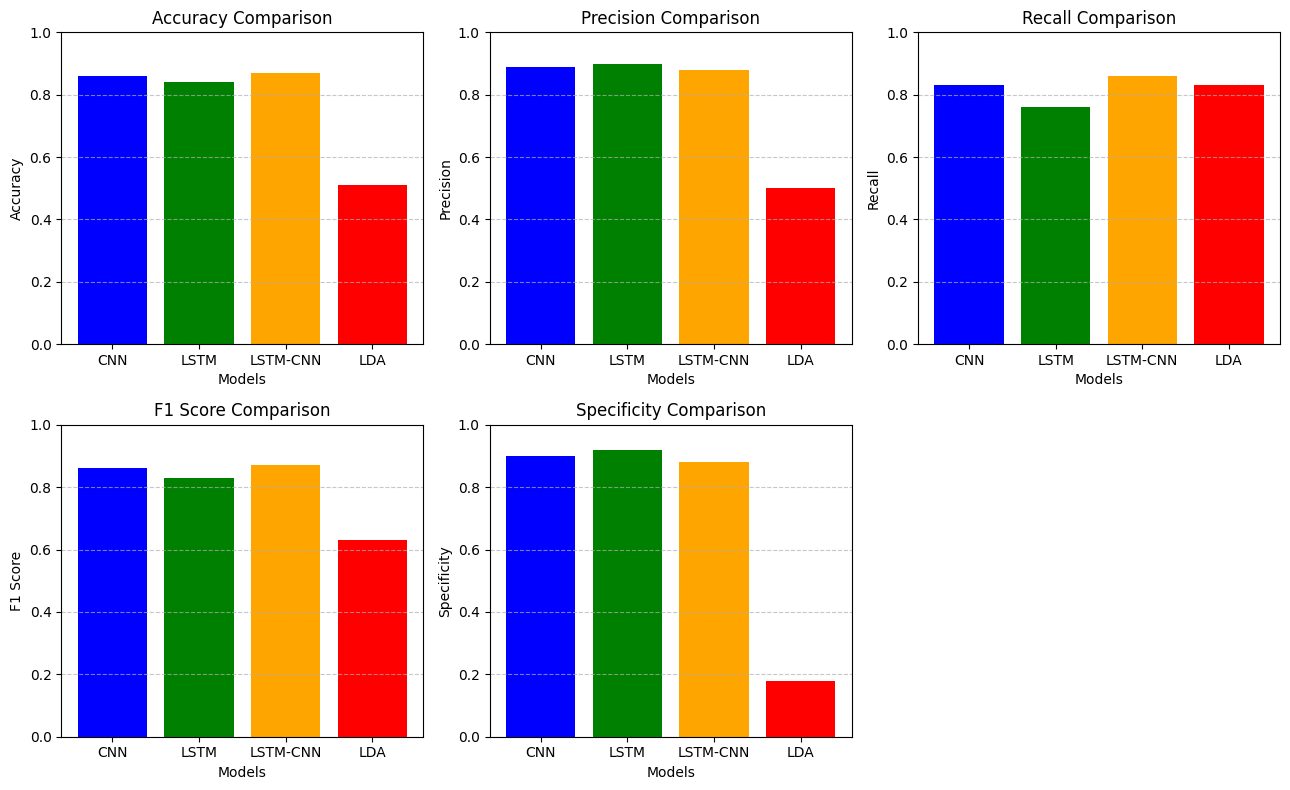

In [ ]:
# Metrics for the models
model_names = ["CNN", "LSTM", "LSTM-CNN", "LDA"]
metrics = {
    "Accuracy": [0.86, 0.84, 0.87, 0.51],
    "Precision": [0.89, 0.90, 0.88, 0.50],
    "Recall": [0.83, 0.76, 0.86, 0.83],
    "F1 Score": [0.86, 0.83, 0.87, 0.63],
    "Specificity": [0.90, 0.92, 0.88, 0.18],
}

# Plot metrics as bar charts
def plot_metrics(metrics, model_names):
    fig, ax = plt.subplots(2, 3, figsize=(13, 8))
    ax = ax.ravel()

    # Loop through metrics and plot
    for i, (metric_name, values) in enumerate(metrics.items()):
        ax[i].bar(model_names, values, color=["blue", "green", "orange", "red"])
        ax[i].set_title(f"{metric_name} Comparison")
        ax[i].set_ylim(0, 1)
        ax[i].set_ylabel(metric_name)
        ax[i].set_xlabel("Models")
        ax[i].grid(axis="y", linestyle="--", alpha=0.7)

    # Hide the last subplot (empty one)
    ax[-1].axis('off')

    plt.tight_layout()
    plt.show()

plot_metrics(metrics, model_names)


### ***Confusion Matrix***

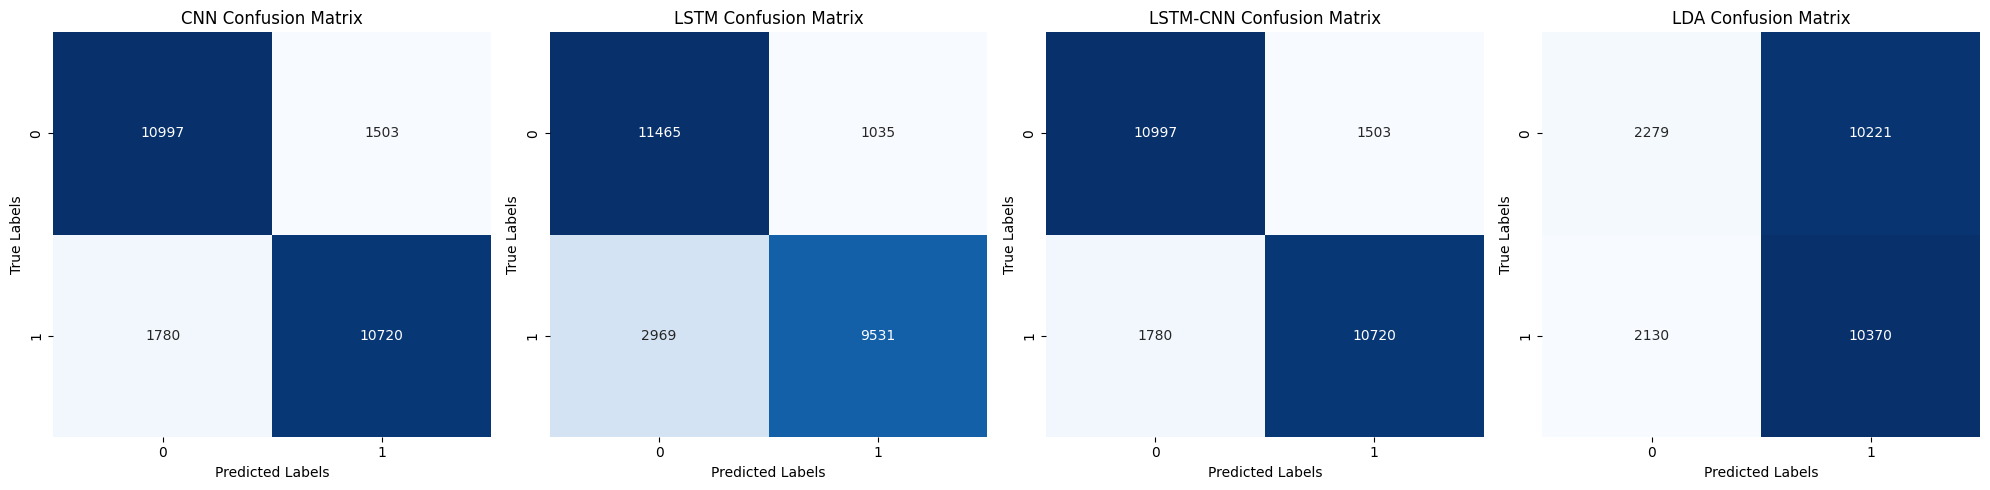

In [ ]:
# Calculate confusion matrices for each model
cm_cnn = confusion_matrix(test_labels, y_pred_labels)
cm_lstm = confusion_matrix(test_labels, y_pred_lstm)
cm_lstm_cnn = confusion_matrix(test_labels, y_pred_labels)
cm_lda = confusion_matrix(test_labels, y_pred_lda)

# Create a 1x5 subplot for each confusion matrix
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot confusion matrices for each model
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title('CNN Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title('LSTM Confusion Matrix')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(cm_lstm_cnn, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[2])
axes[2].set_title('LSTM-CNN Confusion Matrix')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

sns.heatmap(cm_lda, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[3])
axes[3].set_title('LDA Confusion Matrix')
axes[3].set_xlabel('Predicted Labels')
axes[3].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

### ***ROC Curve***

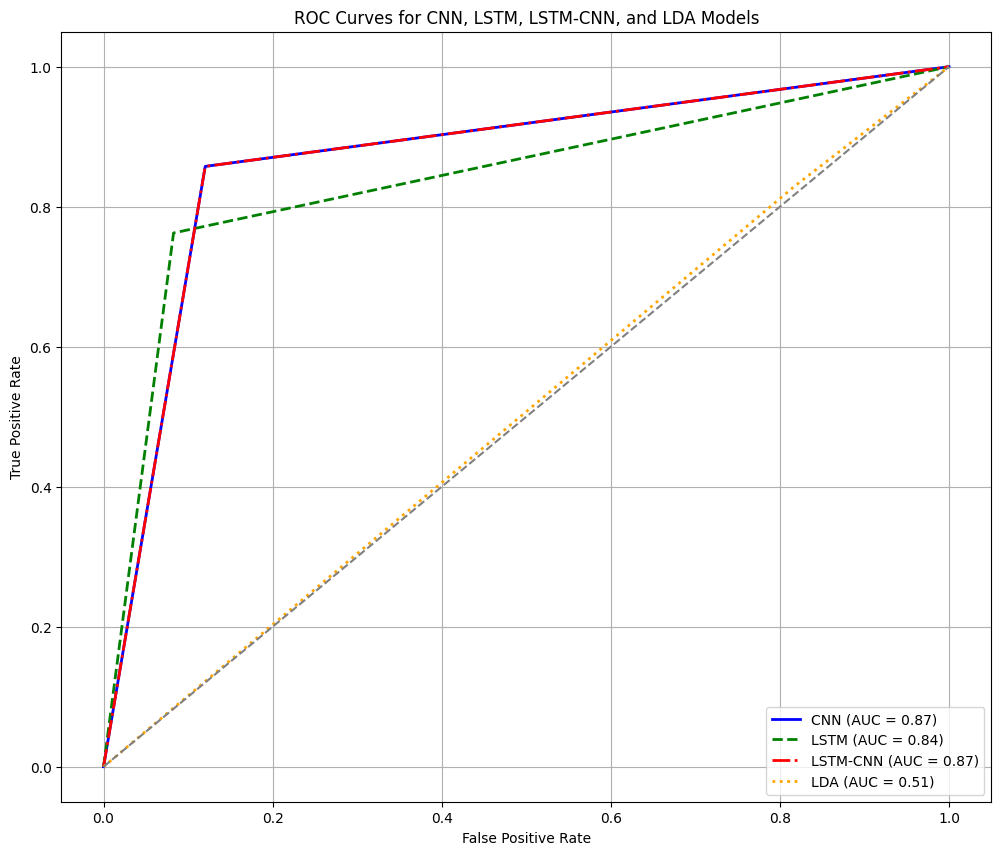

In [ ]:
# Calculate ROC curve (FPR, TPR) for each model
fpr_cnn, tpr_cnn, _ = roc_curve(test_labels, y_pred_labels)
fpr_lstm, tpr_lstm, _ = roc_curve(test_labels, y_pred_lstm)
fpr_lstm_cnn, tpr_lstm_cnn, _ = roc_curve(test_labels, y_pred_labels)
fpr_lda, tpr_lda, _ = roc_curve(test_labels, y_pred_lda)

# Compute AUC for each model
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
roc_auc_lstm_cnn = auc(fpr_lstm_cnn, tpr_lstm_cnn)
roc_auc_lda = auc(fpr_lda, tpr_lda)

# Plot all ROC curves with different line styles and transparency
plt.figure(figsize=(12, 10))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'CNN (AUC = {roc_auc_cnn:.2f})', linestyle='-')
plt.plot(fpr_lstm, tpr_lstm, color='green', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})', linestyle='--')
plt.plot(fpr_lstm_cnn, tpr_lstm_cnn, color='red', lw=2, label=f'LSTM-CNN (AUC = {roc_auc_lstm_cnn:.2f})', linestyle='-.')
plt.plot(fpr_lda, tpr_lda, color='orange', lw=2, label=f'LDA (AUC = {roc_auc_lda:.2f})', linestyle=':')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.title('ROC Curves for CNN, LSTM, LSTM-CNN, and LDA Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ***---------------------------------FINISHED--------------------------------------***